In [1]:
import pandas as pd
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

import numpy as np

import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sn

pd.set_option('display.max_rows', 300) # specifies number of rows to show
pd.options.display.float_format = '{:40,.4f}'.format # specifies default number format to 4 decimal places
plt.style.use('ggplot') # specifies that graphs should use ggplot styling
%matplotlib inline

from scipy.stats import norm
from scipy.stats import stats
import pylab

from statsmodels.stats import diagnostic as dia

C:\Program Files\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='loghousecount'>

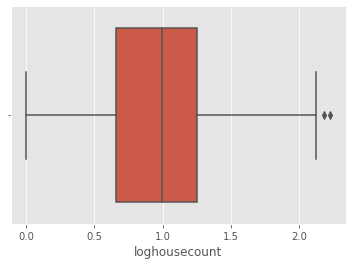

In [3]:
#Outlier test
df = pd.read_csv('Rhousecountlognolsoa3.csv')
sn.boxplot(df['loghousecount'])

In [2]:
#all data has been processed on python, excel and arcmap
xy = pd.read_csv('loghousecount1.csv')
xy.head()

,loghousecount,between2km,close2km
0,0.5346,4.6893,2.6054
1,0.6830,4.1110,2.5145
2,0.3888,4.1744,2.5758
3,1.1758,4.4815,2.5174
4,0.7423,3.5562,2.1194


In [3]:
# calculating VIF
# This function is partially from: https://stackoverflow.com/a/51329496/4667568
from statsmodels.stats.outliers_influence import variance_inflation_factor 
from statsmodels.tools.tools import add_constant

def drop_column_using_vif_(df, thresh=5):
    '''
    Calculates VIF each feature in a pandas dataframe, and repeatedly drop the columns with the highest VIF
    A constant must be added to variance_inflation_factor or the results will be incorrect

    :param df: the pandas dataframe containing only the predictor features, not the response variable
    :param thresh: the max VIF value before the feature is removed from the dataframe
    :return: dataframe with multicollinear features removed
    '''
    while True:
        # adding a constatnt item to the data
        df_with_const = add_constant(df)

        vif_df = pd.Series([variance_inflation_factor(df_with_const.values, i) 
               for i in range(df_with_const.shape[1])], name= "VIF",
              index=df_with_const.columns).to_frame()

        # drop the const
        vif_df = vif_df.drop('const')
        
        # if the largest VIF is above the thresh, remove a variable with the largest VIF
        if vif_df.VIF.max() > thresh:
            # If there are multiple variables with the maximum VIF, choose the first one
            index_to_drop = vif_df.index[vif_df.VIF == vif_df.VIF.max()].tolist()[0]
            print('Dropping: {}'.format(index_to_drop))
            df = df.drop(columns = index_to_drop)
        else:
            # No VIF is above threshold. Exit the loop
            break

    return df

In [4]:
xy_vif= drop_column_using_vif_(xy.drop('loghousecount', axis=1))
print("The columns remaining after VIF selection are:")
print(xy_vif.columns)

The columns remaining after VIF selection are:
Index(['between2km', 'close2km'], dtype='object')


In [5]:
#run OLS model
ols_xy_vif = sm.OLS(endog=xy[['loghousecount']], exog=sm.add_constant(xy_vif)).fit()
ols_xy_vif.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          loghousecount   R-squared:                       0.076
Model:                            OLS   Adj. R-squared:                  0.075
Method:                 Least Squares   F-statistic:                     197.8
Date:                Sun, 05 Sep 2021   Prob (F-statistic):           2.65e-83
Time:                        13:19:57   Log-Likelihood:                -2771.5
No. Observations:                4835   AIC:                             5549.
Df Residuals:                    4832   BIC:                             5568.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.2999      0.064     -4.678      0.000      -0.426      -0.174
between2km     0.2437      0.031      7.899      0.000       0.183       0.304
close2km       0.1421      0.057      2.476      0.013       0.030       0.255
==============================================================================
Omnibus:                      106.369   Durbin-Watson:                   1.571
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              111.589
Skew:                          -0.363   Prob(JB):                     5.87e-25
Kurtosis:                       2.836   Cond. No.                         52.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

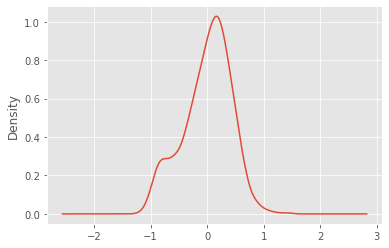

In [6]:
#view residuals
plt.figure()
ols_xy_vif.resid.plot.density()
plt.show()